## Try to see if our S2Si threshold is too high. 
Notebook should work fo runs with trigger on s2, set to 600+mus in buffer

In [1]:
import os
import sys
import tables as tb
import numpy  as np
from matplotlib import pyplot as plt
from glob import glob

from invisible_cities.cities.irene      import Irene
from invisible_cities.types.ic_types_c  import minmax
from invisible_cities.core.system_of_units_c import units
from invisible_cities.core.configure         import configure
from invisible_cities.core     import fit_functions    as fit
from invisible_cities.reco     import peak_functions_c as cpf
from invisible_cities.reco     import peak_functions   as  pf
from invisible_cities.reco     import pmaps_functions  as pmp
from invisible_cities.io       import pmap_io          as pio
from invisible_cities.database import load_db
from invisible_cities.icaro.mpl_functions import circles
from invisible_cities.filters.s1s2_filter    import s1s2_filter
from invisible_cities.filters.s1s2_filter    import S12Selector

In [2]:
ic_data = os.path.join(os.environ['IC_DATA'])

PATH_IN  = ic_data + 'LSC/wvfms/4446/dst_waves.gdcsnext.*_4446.root.h5'
conf_path = '/Users/alej/Desktop/irene/irene.conf'
PATH_OUT  = '/Users/alej/Desktop/irene/full_chain/Kr_4446_full_.1_and_0_thr.h5'
#PATH_OUT  = '/Users/alej/Desktop/irene/full_chain/Kr_4446_full_.5_and_0_thr.h5'
#PATH_OUT  = '/Users/alej/Desktop/irene/full_chain/Kr_4446_full_1.0_and_0_thr.h5'
#PATH_OUT  = '/Users/alej/Desktop/irene/0/irene_pmaps_0.5.h5'
#PATH_OUT  = '/Users/alej/Desktop/IC_DATA/LSC/pmaps/4446/pmaps.gdcsnext.000_4446.root.h5'


pmap_path = PATH_OUT
rwf_path = ic_data + '/LSC/wvfms/4446/dst_waves.gdcsnext.1832_4446.root.h5'

run = 4446
DataSensor  = load_db.DataSiPM(run)
DataPmt     = load_db.DataPMT(run)
active_sipm = DataSensor.Active.values
active_pmt  = DataPmt.Active.values

In [3]:
# initialize irene
def initialize_irene(PATH_IN, PATH_OUT, thr_sipm=1.5*units.pes, thr_sipm_s2=20*units.pes):
    conf     = configure(('dummy ' + conf_path).split()).as_dict
    conf.update(dict(run_number = run,
                     files_in   = PATH_IN,
                     file_out   = PATH_OUT,
                     nmax       = 9e9,
                     s1_tmin    = 0))
    irene = Irene(**conf)
    irene.thr_sipm = thr_sipm
    irene.thr_sipm_s2 = thr_sipm_s2
    return irene

In [4]:
#irene = initialize_irene(PATH_IN, PATH_OUT, thr_sipm=.1*units.pes, thr_sipm_s2=0*units.pes)
#irene.run()

In [34]:
def get_evs_with_one_s1_and_s2(s1_dict, s2_dict, s2si_dict):
    events_with_one_s1_and_s2 = []
    for ev in s1_dict:
        if ev not in s2_dict or ev not in s2si_dict: continue
        if s1_dict[ev].number_of_peaks !=1: continue
        if s2_dict[ev].number_of_peaks !=1: continue
        if 0 in s2si_dict[ev].s2sid: events_with_one_s1_and_s2.append(ev)
    return np.array(events_with_one_s1_and_s2)
def get_drift_times(events_i, s1_dict, s2_dict):
    return np.array([s2_dict[ev].peaks[0].tpeak - s1_dict[ev].peaks[0].tpeak for ev in events_i])
def get_nsipms_in_s2si(events_i, s2si_dict):
    return np.array([s2si_dict[ev].number_of_sipms_in_peak(0) for ev in events_i])
def get_s2si_length(events_i, s2_dict):
    return np.array([len(s2_dict[ev].peaks[0].t) for ev in events_i])
def get_s2si_integrals(events_i, s2si_dict):
    return np.array([np.sum(list(s2si_dict[ev].sipm_total_energy_dict(0).values())) for ev in events_i])
def raise_thrs_and_collect(s1_dict, s2_dict, s2si_dict, THR_SIPM, THR_SIPM_S2):
    DRIFT_TS = [[] for thr_sipm in THR_SIPM]
    NSIPMS   = [[] for thr_sipm in THR_SIPM]
    S2SI_LEN = [[] for thr_sipm in THR_SIPM]
    S2SI_QS  = [[] for thr_sipm in THR_SIPM]
    for i, (thr_sipm, thr_sipm_s2) in enumerate(zip(THR_SIPM, THR_SIPM_S2)):
        s2si_dict = pmp.raise_s2si_thresholds_destructive(s2si_dict, thr_sipm, thr_sipm_s2)
        print('thr_sipm, thr_sipm_s2:', (thr_sipm, thr_sipm_s2), 'Done.')
        events_i  = get_evs_with_one_s1_and_s2(s1_dict, s2_dict, s2si_dict)
        DRIFT_TS[i].append(get_drift_times(events_i, s1_dict, s2_dict))
        NSIPMS  [i].append(get_nsipms_in_s2si(events_i, s2si_dict))
        S2SI_LEN[i].append(get_s2si_length(events_i, s2si_dict))
        S2SI_QS [i].append(get_s2si_integrals(events_i, s2si_dict))
    return np.array(DRIFT_TS), np.array(NSIPMS  ), np.array(S2SI_LEN), np.array(S2SI_QS )

In [47]:
def relevant_plots(DRIFT_TS, NSIPMS, S2SI_LEN, S2SI_QS, THR_SIPM, THR_SIPM_S2):
    plt.figure(figsize=(20,8))
    for thr_sipm, thr_sipm_s2, drift_ts, s2si_len in zip(THR_SIPM, THR_SIPM_S2, DRIFT_TS, S2SI_LEN):
        plt.scatter(drift_ts / units.mus, s2si_len, alpha=.2, label=(thr_sipm, thr_sipm_s2))
        plt.xlabel('Drift Time (mus)')
        plt.ylabel('Lenght of s2si (mus)')
        plt.legend()
        plt.grid(True)
    plt.show()
    plt.figure(figsize=(20,8))
    for thr_sipm, thr_sipm_s2, drift_ts, nsipms in zip(THR_SIPM, THR_SIPM_S2, DRIFT_TS, NSIPMS):
        plt.scatter(drift_ts / units.mus, nsipms, alpha=.2, label=(thr_sipm, thr_sipm_s2))
        plt.xlabel('Drift Time (mus)')
        plt.ylabel('Number of SiPMs that saw at least some of the s2si (passed thr cuts)')
        plt.grid(True)
        plt.legend()
    plt.show()
    plt.figure(figsize=(20,8))
    for thr_sipm, thr_sipm_s2, drift_ts, s2si_qs in zip(THR_SIPM, THR_SIPM_S2, DRIFT_TS, S2SI_QS):
        plt.scatter(drift_ts / units.mus, s2si_qs, alpha=.2, label=(thr_sipm, thr_sipm_s2))
        plt.ylabel('s2si integral charge (pes)')
        plt.xlabel('Drift Time (mus)')
        plt.grid(True)
        plt.ylim(None, 3000)
        plt.legend()
    plt.show()

In [48]:
THR_SIPM    = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
THR_SIPM_S2 = [None for thr in THR_SIPM]
#DRIFT_TS, NSIPMS, S2SI_LEN, S2SI_QS = raise_thrs_and_collect(*pio.load_pmaps(pmap_path), THR_SIPM, THR_SIPM_S2)

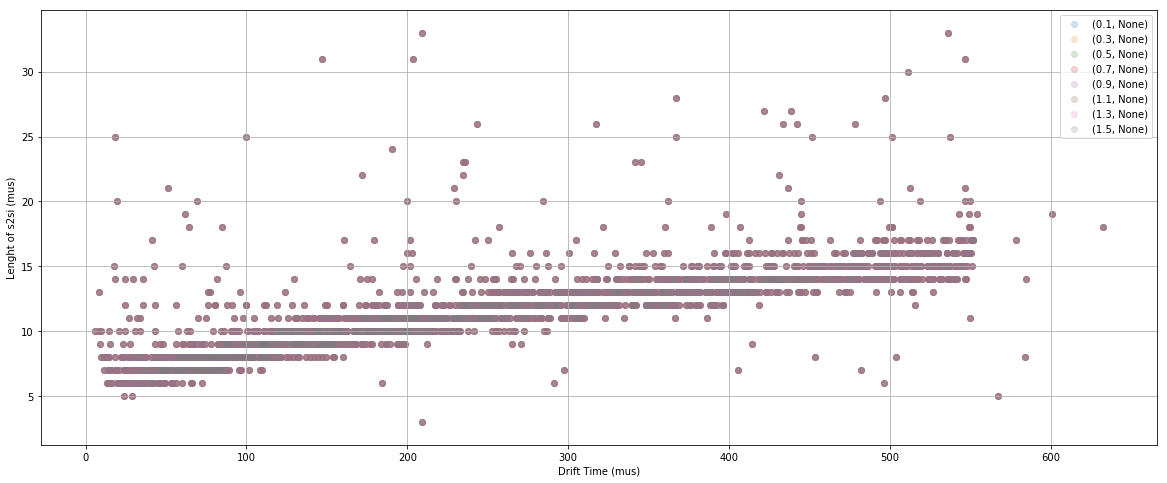

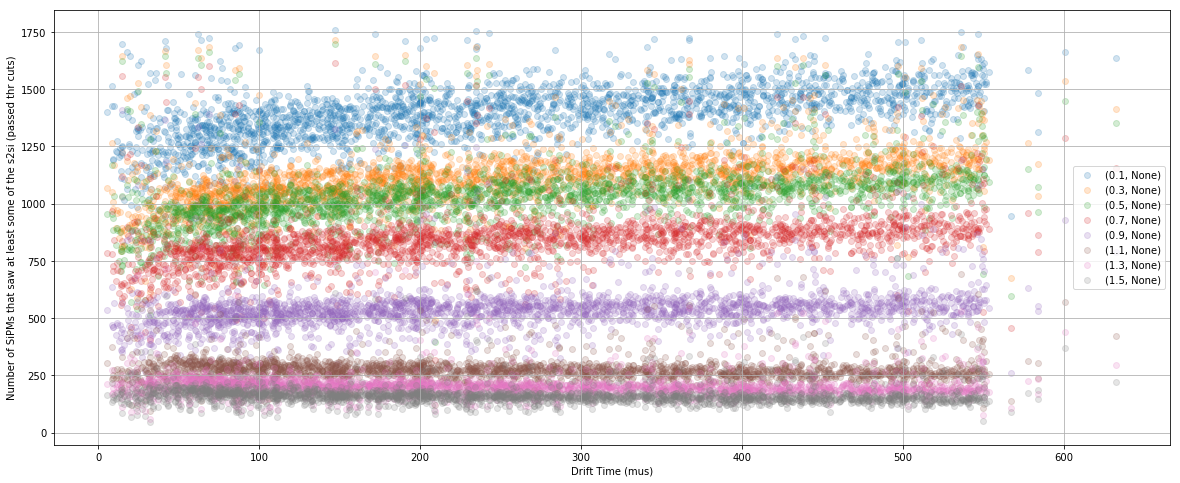

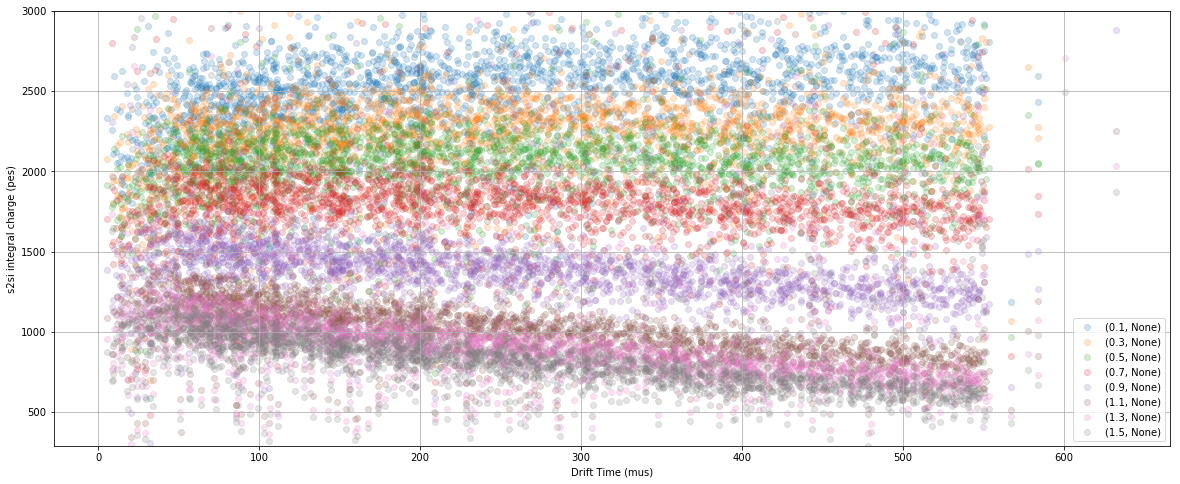

In [49]:
relevant_plots(DRIFT_TS, NSIPMS, S2SI_LEN, S2SI_QS, THR_SIPM, THR_SIPM_S2)    

thr_sipm, thr_sipm_s2: (1, 2) Done.
thr_sipm, thr_sipm_s2: (1, 3) Done.
thr_sipm, thr_sipm_s2: (1, 4) Done.
thr_sipm, thr_sipm_s2: (1, 5) Done.
thr_sipm, thr_sipm_s2: (1, 6) Done.
thr_sipm, thr_sipm_s2: (1, 7) Done.
thr_sipm, thr_sipm_s2: (1, 8) Done.
thr_sipm, thr_sipm_s2: (1, 9) Done.


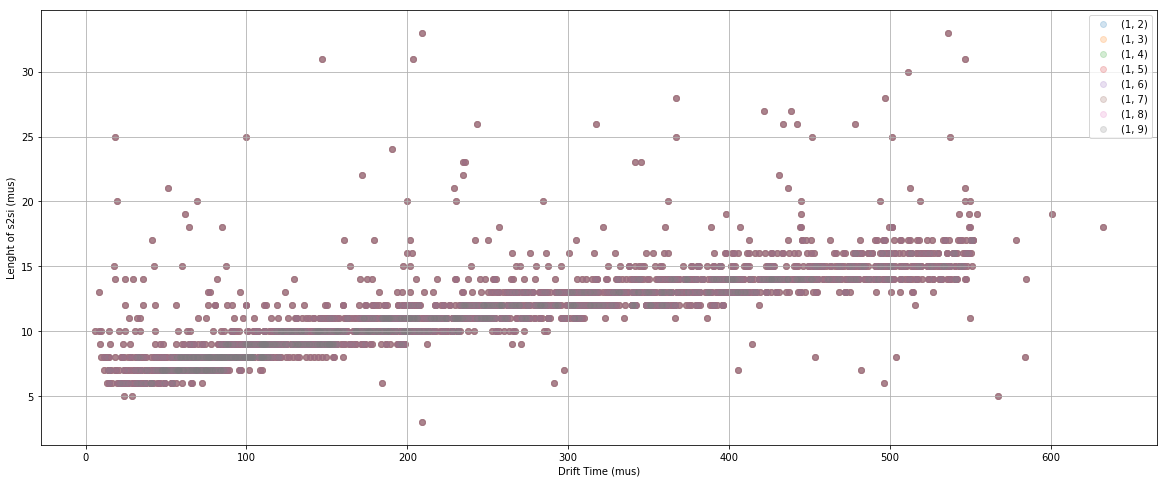

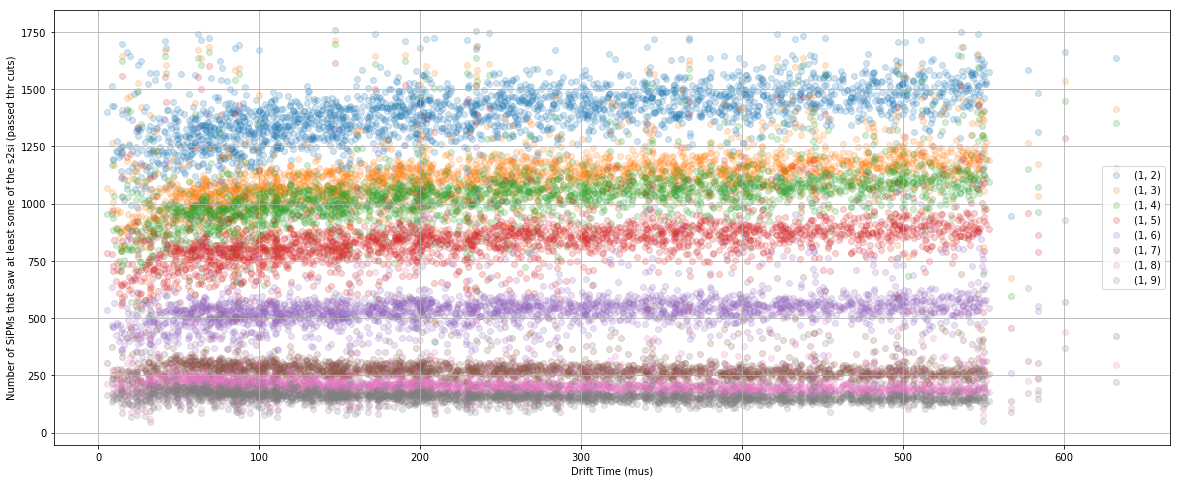

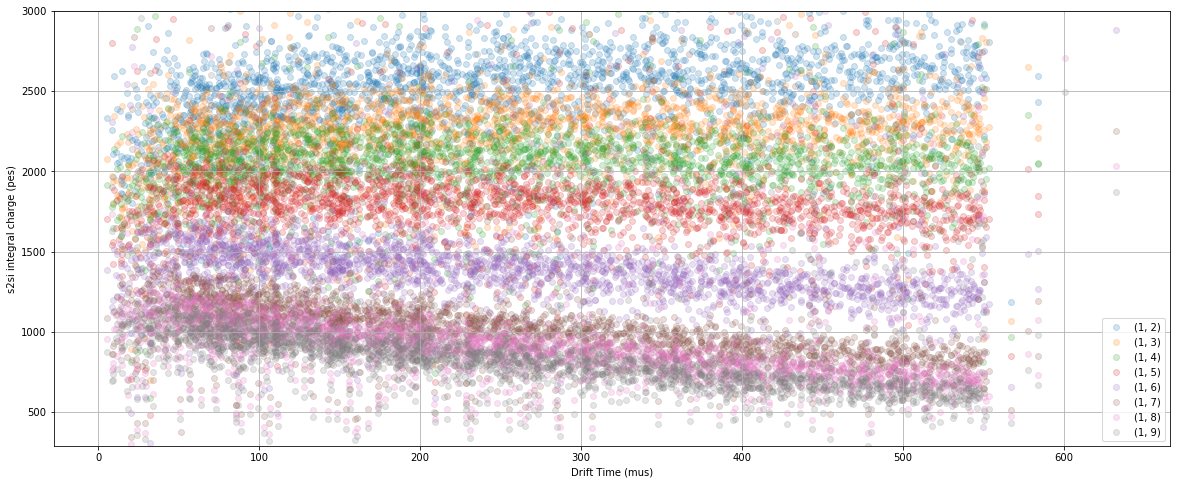

In [55]:
THR_SIPM_S2 = list(range(2,10))
THR_SIPM    = [1 for thr in THR_SIPM_S2]
DRIFT_TS1, NSIPMS1, S2SI_LEN1, S2SI_QS1 = raise_thrs_and_collect(*pio.load_pmaps(pmap_path), THR_SIPM, THR_SIPM_S2)
relevant_plots(DRIFT_TS, NSIPMS, S2SI_LEN, S2SI_QS, THR_SIPM, THR_SIPM_S2)            